In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(Signac))
suppressPackageStartupMessages(library(harmony))
suppressPackageStartupMessages(library(EnsDb.Mmusculus.v79))
source("/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/05.R/DPT_help.R") ### helper code

In [8]:
getwd()
subdir <- "."

[1] "/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/05.R/Preprocess"

# Clustering of Gene expression

In [ ]:
path <- "/oasis/tscc/scratch/y2xie/28.FC_16k_Droplet_PT_221210/"
rna_source <- data.frame(sample = c("YX796", "YX797", "YX839", "YX840", "YX841", "YX842"))

In [4]:
### in multiome, barcodes for rna and dna is different. You can get the barcode pairing relationship
### in cellranger repo. More information you can check: 
### https://kb.10xgenomics.com/hc/en-us/articles/360049105612-Barcode-translation-in-Cell-Ranger-ARC
translate <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", 
        header = T, row.names = 1, sep = "\t")
translate$atac <- paste0(translate$atac, "-1")
translate$rna <- paste0(translate$rna, "-1")

In [6]:
### filter raw matrix with PF nuclei from both modalities
mtx_list <- list()
for (f in rna_source$sample){
    counts <- Read10X(paste0(path, f, "/outs/raw_feature_bc_matrix"))
    ff <- list.files(path = paste0(path, "05.R/PF_cells/"), pattern = paste0(f, ".*_dual_frip_valid_cells.txt")) ### pass-filtered barcodes
    dual_pf <- read.table(paste0(path, "05.R/PF_cells/", ff), header = T, sep = "\t")
    counts <- counts[, dual_pf$rna_bc]
    colnames(counts) <- paste0(f, ":", colnames(counts))
    mtx_list[[f]] <- counts
}

mtx <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) 
mmg <- CreateSeuratObject(mtx)

### save matrix in 10X format for calculation
system("mkdir FC_RNA_merged_mtx")
writeMM(mmg@assays$RNA@counts, file = "FC_RNA_merged_mtx/matrix.mtx")
write.table(colnames(mmg), file = "FC_RNA_merged_mtx/barcodes.tsv", sep = "\t", quote = F, row.names = F, col.names = F)
write.table(rownames(mmg), file = "FC_RNA_merged_mtx/genes.tsv", sep = "\t", quote = F, row.names = F, col.names = F)

In [7]:
### QC calculation and filtering
mmg$sample <- substr(colnames(mmg), 0, 5)
### assign barcodes
mmg$bc <- gsub("^([^:]+):(.*)$", "\\2", colnames(mmg))
mmg$atac_bc <- translate[match(mmg$bc, translate$rna), "atac"]
### assign libraries
mmg$arc <- NA
mmg@meta.data[mmg$sample == "YX796", ]$arc <- "YX794_YX796"
mmg@meta.data[mmg$sample == "YX797", ]$arc <- "YX795_YX797"
mmg@meta.data[mmg$sample == "YX839", ]$arc <- "YX835_YX839"
mmg@meta.data[mmg$sample == "YX840", ]$arc <- "YX836_YX840"
mmg@meta.data[mmg$sample == "YX841", ]$arc <- "YX837_YX841"
mmg@meta.data[mmg$sample == "YX842", ]$arc <- "YX838_YX842"
mmg$percent.mt <- PercentageFeatureSet(mmg, pattern = "^mt-")
mmg$percent.ribo <- PercentageFeatureSet(mmg, pattern = "(^Rpl|^Rps|^Mrp)")
gene_lcf <- median(log10(mmg$nFeature_RNA)) - 3*mad(log10(mmg$nFeature_RNA))
gene_hcf <- median(log10(mmg$nFeature_RNA)) + 3*mad(log10(mmg$nFeature_RNA))
count_hcf <- median(log10(mmg$nCount_RNA)) + 3*mad(log10(mmg$nCount_RNA))

mmg <- subset(mmg, subset = nCount_RNA < 15000 & nFeature_RNA > 10^gene_lcf & nFeature_RNA < 10^gene_hcf & percent.mt < 10 & percent.ribo < 20)
mmg

An object of class Seurat 
32285 features across 26061 samples within 1 assay 
Active assay: RNA (32285 features, 0 variable features)

## Doublet removal: scrublet

In [11]:
system("mkdir scrublet")
for (f in rna_source$sample){
    ### scrublet by libary 
    fcells <- rownames(mmg@meta.data[mmg$sample == f, ])
    mtx_list[[f]] <- mtx_list[[f]][, fcells]
    Matrix::writeMM(mtx_list[[f]], file = paste0("scrublet/", f, "_PF_cells.mtx"))
    write.table(colnames(mtx_list[[f]]), 
                file = paste0("scrublet/", f, "_PF_cells.txt"), 
                quote = F, sep = "\t", row.names = F, col.names = F)
    system(paste0("python RunScrublet.py --input ", "scrublet/", f, "_PF_cells.mtx ", 
                  "--cells ", "scrublet/", f, "_PF_cells.txt ", 
                  "--output ", "scrublet/", f))
}

In [13]:
doublet_list <- list()
### filtering with manual inspection
doublet_cutoff <- data.frame(sample = rna_source$sample,
                             cutoff = rep(0.25, times = nrow(rna_source)))
for (i in 1:nrow(rna_source)){
    tmp <- read.csv(paste0("scrublet/", rna_source$sample[i], "_scrublet.csv"), row.names = 1)
    tmp$manual <- "False"
    tmp[tmp$score > doublet_cutoff[i, "cutoff"], ]$manual <- "True"
    doublet_list[[i]] <- tmp
}
doublet_list <- do.call(rbind, doublet_list)
doublet_list$sample <- substr(rownames(doublet_list), 0, 5)

mmg$scrublet_score <- doublet_list[colnames(mmg),]$score
mmg$scrublet_ident <- doublet_list[colnames(mmg),]$manual

Regressing out percent.mt

Centering and scaling data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"
Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23611
Number of edges: 905882

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9386
Number of communities: 23
Elapsed time: 3 seconds


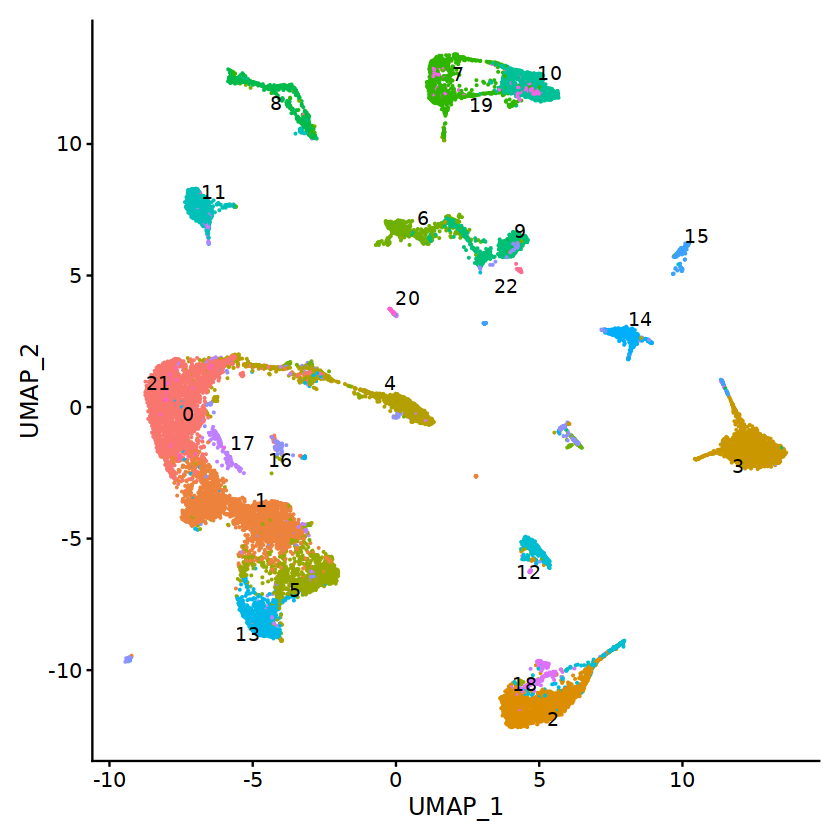

In [17]:
### Clustering after doublet removal
tmp2 <- subset(mmg, subset = scrublet_ident == "False")
tmp2 <- RunRNA(tmp2, var = "percent.mt", batch.label = "sample")
tmp2 <- FindNeighbors(object = tmp2, k.param = 25, verbose = F)
tmp2 <- FindClusters(object = tmp2, resolution = 0.6)
DimPlot(tmp2, label = T, repel = T) + NoLegend()

In [ ]:
saveRDS(tmp2, "FC_RNA_Seurat_merged_rmScrublet.rds")

After manual annotation, we excluded clusters with ambiguous identities (ie, without clear markers or have markers from obvious conflicting cell types) for downstream analysis. 
This results in a total set of 22,054 nuclei

# Clustering of Histone modification
## Use Signac to generate genome bin

In [22]:
mm10 <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/mm10.main.chrom.sizes", row.names = 1)
mm10 <- t(mm10) %>% as.data.frame()

annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotations) <- 'UCSC'

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [23]:
### this is the cutoff used for valid barcodes selection in 01.Pre-process
cutoff <- data.frame(sample = c("YX794", "YX795", "YX835", "YX836", "YX837", "YX838"),
                   xcut = c(1200, 1000, 800, 500, 750, 500),
                   ycut = c(0.1, 0.3, 0.05, 0.15, 0.15, 0.35), 
                   ycut2 = c(0.45, 0.95, 0.40, 0.75, 0.55, 0.8))

In [ ]:
### genrate cell by bin matrix
for (f in cutoff[[1]]){
    valid <- read.table(paste0(path, "05.R/", f, "_PF_cells.txt"))
    frags <- CreateFragmentObject(paste0(path, f, "/outs/fragments.tsv.gz"), cells = valid$V1)
    obj <- GenomeBinMatrix(frags, genome = unlist(mm10), cells = valid$V1, binsize = 5000)
    saveRDS(obj, paste0(f, "_GenomeBin_5k.mtx.rds"))
}

Computing hash

Extracting reads overlapping genomic regions



## H3K27ac clustering

In [27]:
H3K27ac <- c("YX794", "YX835", "YX837")

In [30]:
### Get common features foor merging. Only extract exact same bins from all mtx 
mtx_list <- list()
for (f in H3K27ac){
    counts <-  readRDS(paste0(f, "_GenomeBin_5k.mtx.rds"))
    mtx_list[[f]] <- counts
}

commonf <- Reduce(intersect, lapply(mtx_list, rownames))

Computing hash

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from dna to dna_"
Running SVD

Scaling cell embeddings



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18076
Number of edges: 862774

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9424
Number of communities: 22
Elapsed time: 2 seconds


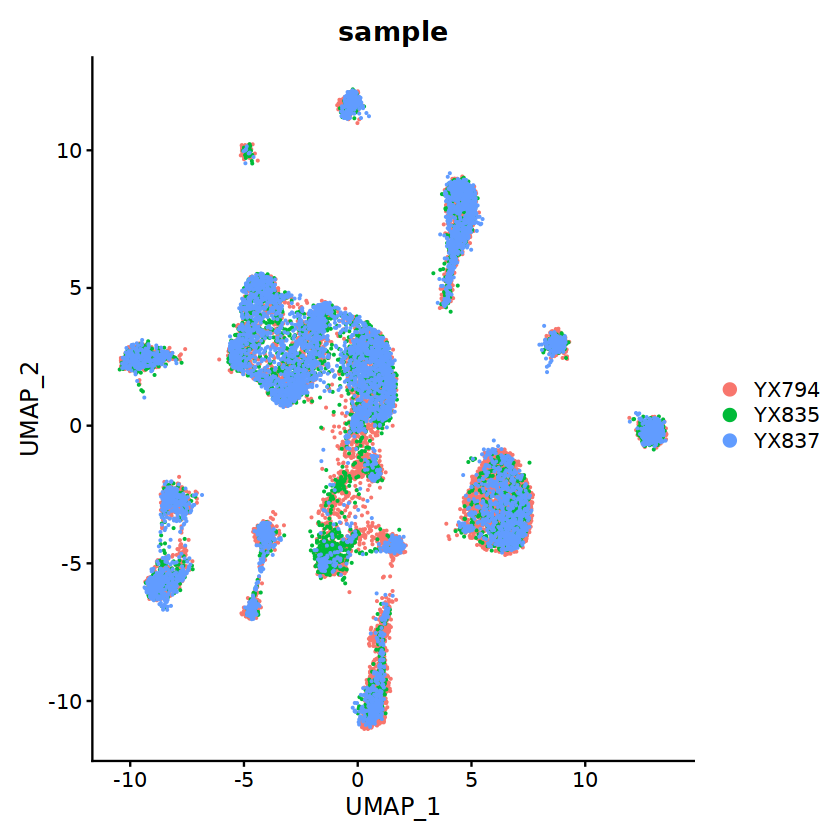

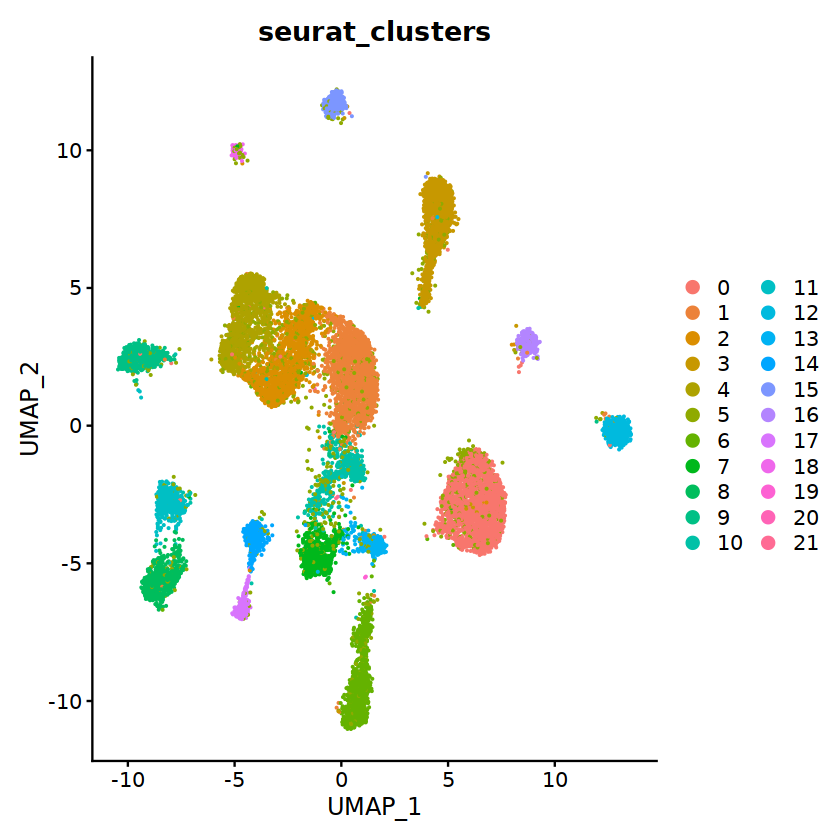

In [32]:
### clustering on all samples
### merge all fragments file into one big file: FC_H3K27ac_merged_fragments.tsv.gz

for (f in H3K27ac){
    mtx_list[[f]] <- mtx_list[[f]][commonf, ]
    colnames(mtx_list[[f]]) <- paste0(f, ":", colnames(mtx_list[[f]]))
}

mtx <- Reduce(cbind, mtx_list[-1], mtx_list[[1]])

### Add fragments file
mtx <- CreateChromatinAssay(counts = mtx, sep = c(":", "-"), genome = "mm10", 
                             fragments = paste0(path, "03.mapping/FC_H3K27ac_merged_fragments.tsv.gz"), 
                             min.cells = 5, min.features = 5)
mmg <- CreateSeuratObject(mtx, assay = "DNA")
mmg$sample <- substr(colnames(mmg), 0, 5)
Annotation(mmg) <- annotations
mmg <- FindTopFeatures(mmg, min.cutoff = 'q15')
mmg <- RunTFIDF(mmg, method = 3, verbose = F)
mmg <- RunSVD(mmg)
### harmony
mmg <- RunHarmony(mmg, group.by.vars = "sample", reduction = "lsi", assay.use = "DNA", project.dim = F, verbose = F)
mmg <- RunUMAP(mmg, reduction = "harmony", dims = 2:30, verbose = F)

mmg <- FindNeighbors(object = mmg, reduction = 'harmony', dims = 2:30, verbose=F)
mmg <- FindClusters(object = mmg, resolution = 0.5)

### check umap
### remember, this is all H3K27ac nuclei without RNA filtering!
p1 <- DimPlot(mmg, group.by = "sample")
p2 <- DimPlot(mmg, group.by = "seurat_clusters")
p1
p2

You may find that the UMAP embedding is inconsistent with the UMAP shown in our Fig.2a.

This is because of the selection of different random seed in the stochastic UMAP algorithm, which makes use of randomness both to speed up approximation steps. Below we specify the random seed used during UMAP and Louvian clustering to recaptiluate the original results.

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18076
Number of edges: 861599

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9428
Number of communities: 21
Elapsed time: 3 seconds


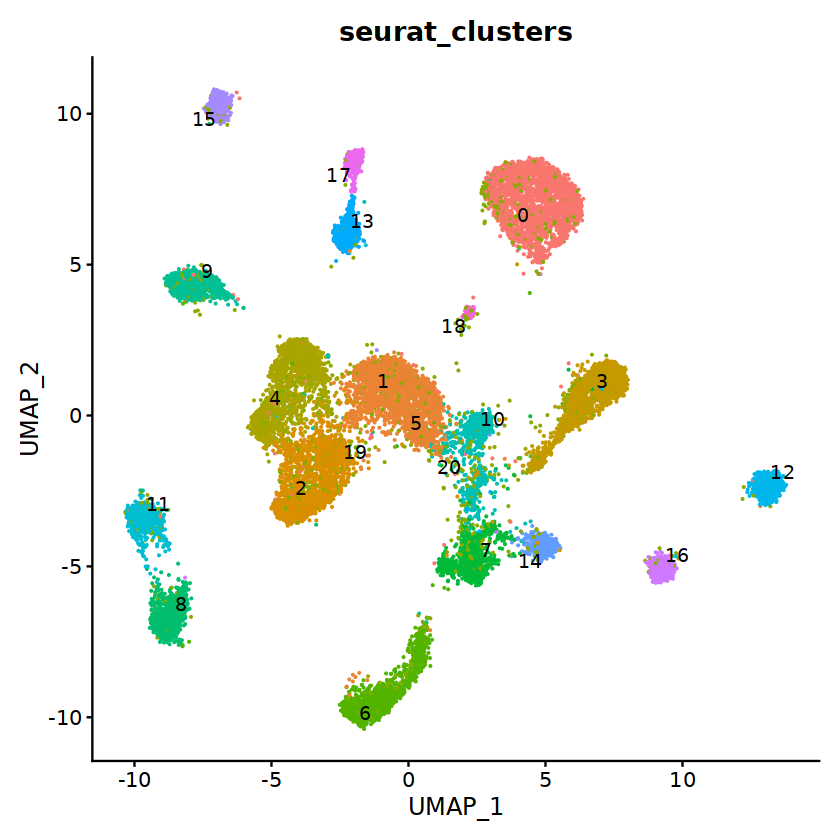

In [3]:
mmg <- RunUMAP(mmg, reduction = "harmony", dims = 2:30, verbose = F, 
               seed.use = 42) ### seed 42 for UMAP
mmg <- FindNeighbors(object = mmg, reduction = 'harmony', dims = 2:30, verbose = F)
mmg <- FindClusters(object = mmg, resolution = 0.5, algorithm = 1, 
                    random.seed = 0) ### seed 0 for the original Louvian clustering (algorithm = 1)

DimPlot(mmg, group.by = "seurat_clusters", label = T, repel = T) + NoLegend()

In [ ]:
gene.activities <- GeneActivity(mmg)
mmg[["GA"]] <- CreateAssayObject(counts = gene.activities)
mmg <- NormalizeData(mmg, assay = "GA", normalization.method = "LogNormalize", 
                     scale.factor = median(mmg$nCount_GA))

In [ ]:
saveRDS(mmg, "FC_H3K27ac_signac_merged.rds")

After manual annotation, we excluded clusters with ambiguous identities (ie, when paired with transcriptome profiles, doesnt have clear corresponding clusters) for downstream analysis. This results in a total set of 11,874 nuclei with both high quality RNA + histone profile

## H3K27me3 clustering

In [33]:
H3K27me3 <- c("YX795", "YX836", "YX838")

Computing hash

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from dna to dna_"
Running SVD

Scaling cell embeddings



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15646
Number of edges: 846603

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9543
Number of communities: 22
Elapsed time: 1 seconds


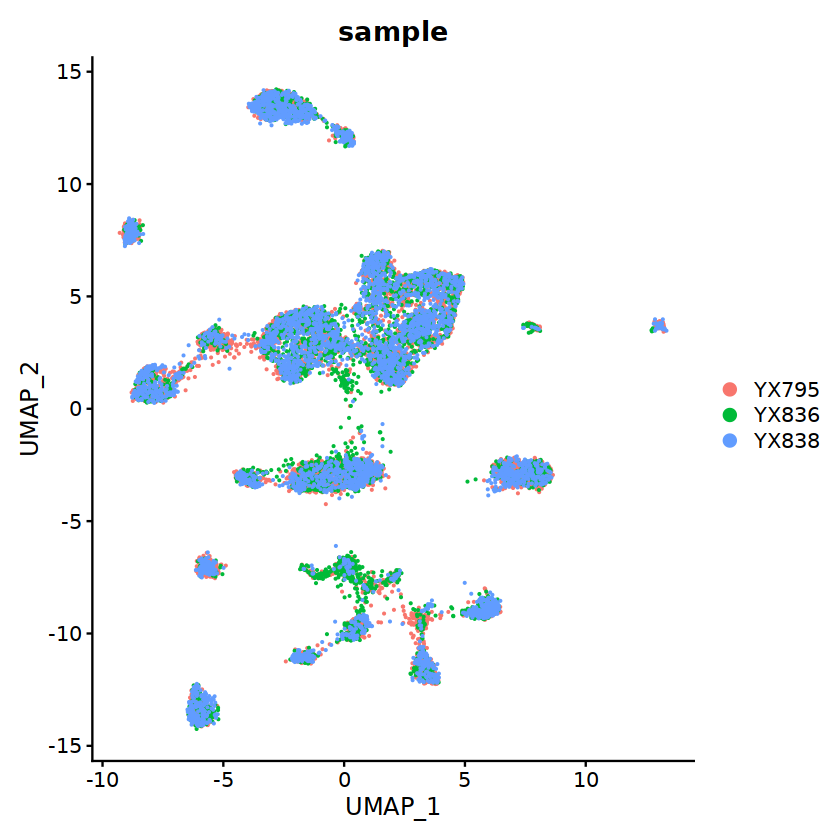

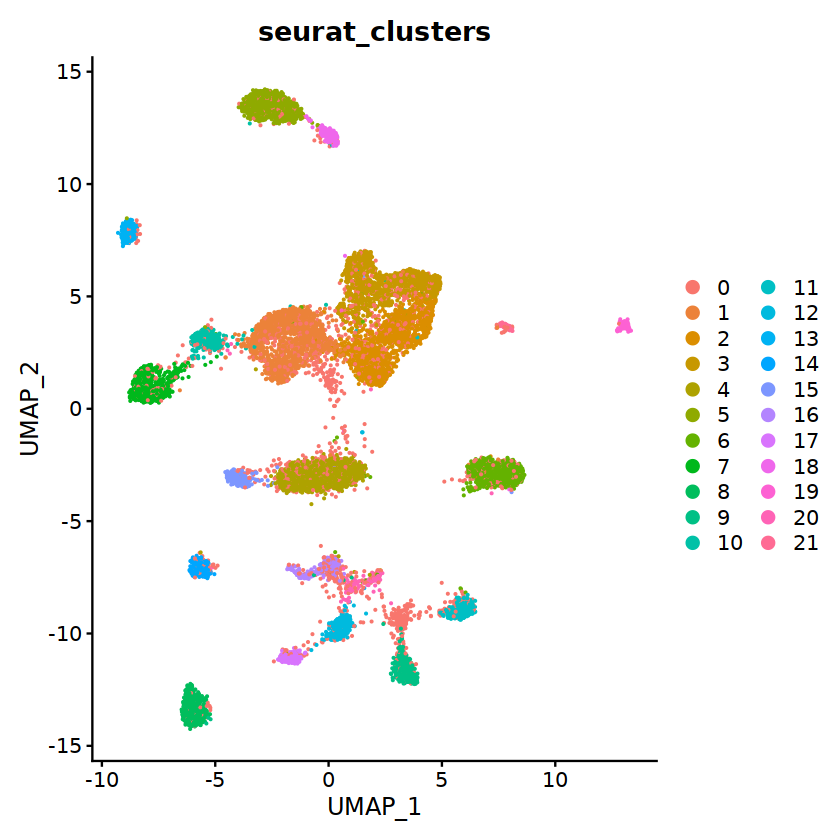

In [36]:
mtx_list <- list()
for (f in H3K27me3){
    counts <-  readRDS(paste0(f, "_GenomeBin_5k.mtx.rds"))
    mtx_list[[f]] <- counts
}

commonf <- Reduce(intersect, lapply(mtx_list, rownames))

for (f in H3K27me3){
    mtx_list[[f]] <- mtx_list[[f]][commonf, ]
    colnames(mtx_list[[f]]) <- paste0(f, ":", colnames(mtx_list[[f]]))
}

mtx <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) ### dont use do.call for cbind
mtx <- CreateChromatinAssay(counts = mtx, sep = c(":", "-"), genome = "mm10", 
                             fragments = paste0(path, "03.mapping/FC_H3K27me3_merged_fragments.tsv.gz"), 
                             min.cells = 5, min.features = 5)
mmg <- CreateSeuratObject(mtx, assay = "DNA")
mmg$sample <- substr(colnames(mmg),0,5)
Annotation(mmg) <- annotations
mmg <- FindTopFeatures(mmg, min.cutoff = 'q15')
mmg <- RunTFIDF(mmg, method = 3, verbose = F)
mmg <- RunSVD(mmg)
### harmony
mmg <- RunHarmony(mmg, group.by.vars = "sample", reduction = "lsi", assay.use = "DNA", project.dim = F, verbose = F)
mmg <- RunUMAP(mmg, reduction = "harmony", dims = 2:30, verbose = F)

mmg <- FindNeighbors(object = mmg, reduction = 'harmony', dims = 2:30, verbose=F)
mmg <- FindClusters(object = mmg, resolution = 0.5)
p1 <- DimPlot(mmg, group.by = "sample")
p2 <- DimPlot(mmg, group.by = "seurat_clusters")
### remember, this is all H3K27me3 nuclei without RNA filtering!
p1
p2

Alter random seed in UMAP to be consistent with our manuscript:

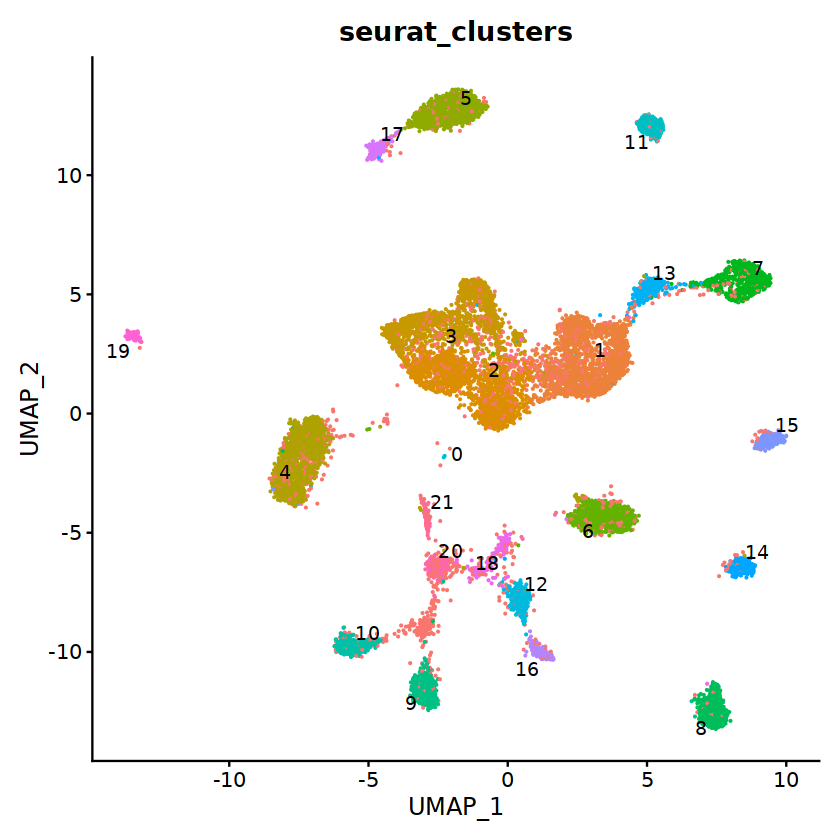

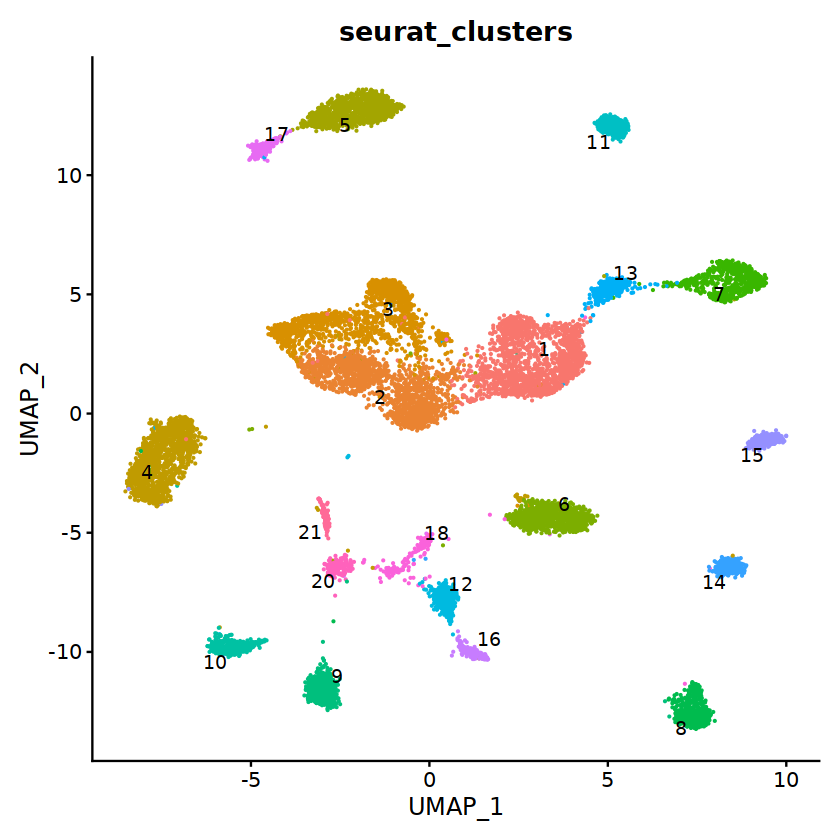

In [5]:
mmg <- RunUMAP(mmg, reduction = "harmony", dims = 2:30, verbose = F, 
               seed.use = 42) ### seed 42 for UMAP
mmg <- FindNeighbors(object = mmg, reduction = 'harmony', dims = 2:30, verbose = F)
mmg <- FindClusters(object = mmg, resolution = 0.5, algorithm = 1, 
                    random.seed = 0) ### seed 0 for the original Louvian clustering (algorithm = 1)

DimPlot(mmg, group.by = "seurat_clusters", label = T, repel = T) + NoLegend()
### remove low quality group
DimPlot(mmg, group.by = "seurat_clusters", label = T, repel = T, 
        cells = rownames(mmg@meta.data[mmg$DNA_keep_cells == "True", ])) + NoLegend()

In [ ]:
gene.activities <- GeneActivity(mmg)
mmg[["GA"]] <- CreateAssayObject(counts = gene.activities)
mmg <- NormalizeData(mmg, assay = "GA", normalization.method = "LogNormalize", 
                     scale.factor = median(mmg$nCount_GA))

In [ ]:
saveRDS(mmg, "FC_H3K27me3_signac_merged.rds")

After manual annotation, we excluded nuclei with ambiguous identities (ie, when paired with transcriptome profiles, doesnt have clear corresponding clusters) for downstream analysis. This results in a total set of 10,180 nuclei with both high quality RNA + histone profile

## Compare RNA vs DNA clustering

In [ ]:
### After manual annotations...
d1 <- readRDS("FC_H3K27ac_signac_merged.rds")
d2 <- readRDS("FC_H3K27me3_signac_merged.rds")
mmg <- readRDS("FC_RNA_Seurat_merged_rmScrublet.rds")

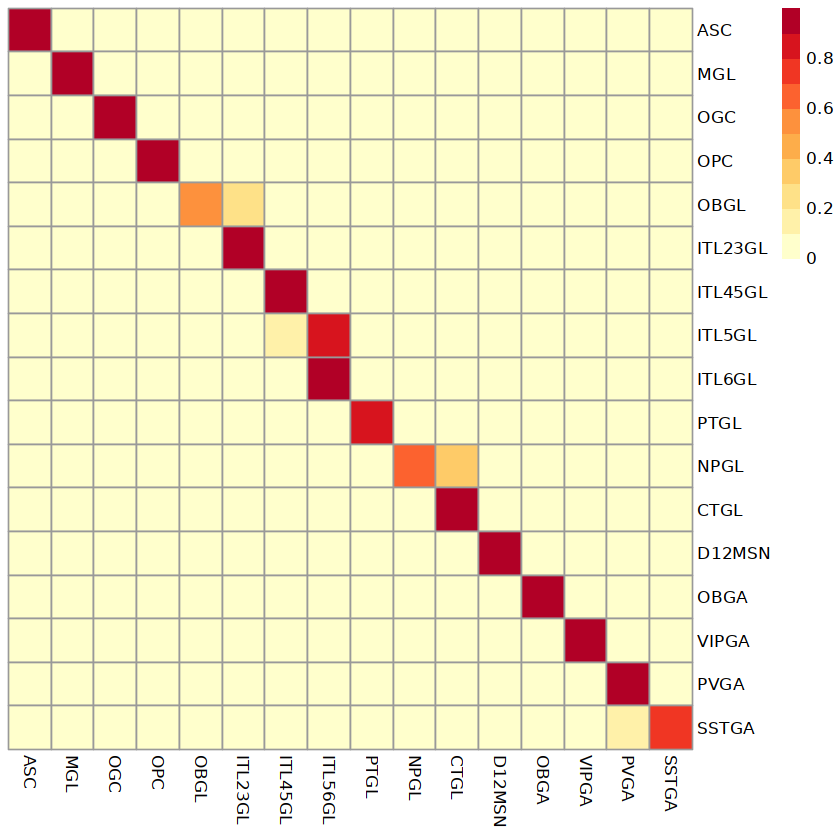

In [40]:
### H3K27ac: valid nuclei selection
d1meta <- d1@meta.data[d1$DNA_keep_cells == "True" & d1$RNA_keep_cells == "True", 
                   c("rna_Anno0.8_yel", "dna_Anno0.8_transfer")]
### modify annotation: VIP
d1meta[grep("VIPGA", d1meta$dna_Anno0.8_transfer), ]$dna_Anno0.8_transfer <- "VIPGA"

### levels for plotting: 
rorder <- c("ASC", "MGL", "OGC", "OPC", "OBGL", 
            "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL",
            "D12MSN", "OBGA", "VIPGA", "PVGA", "SSTGA")
dorder <- c("ASC", "MGL", "OGC", "OPC", "OBGL", 
            "ITL23GL", "ITL45GL", "ITL56GL", "PTGL", "NPGL", "CTGL",
            "D12MSN", "OBGA", "VIPGA", "PVGA", "SSTGA")
d1cfm <- table(d1meta[, c("rna_Anno0.8_yel", "dna_Anno0.8_transfer")]) %>% as.matrix
d1cfm <- (d1cfm / rowSums(d1cfm)) 
plt1 <- d1cfm[rorder, dorder] %>% 
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F,
        color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))

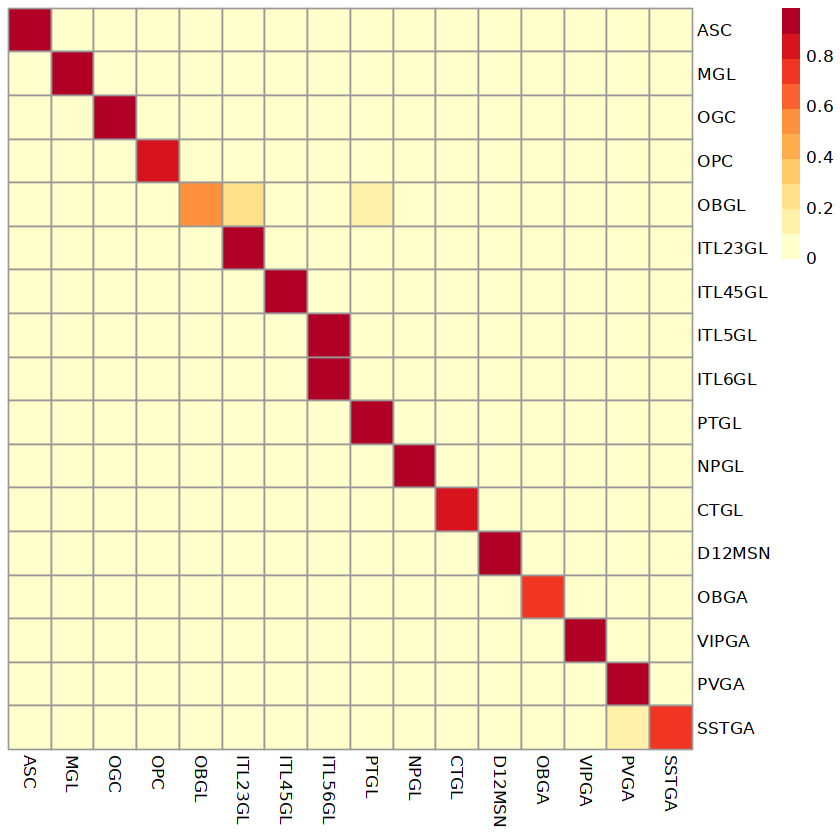

In [42]:
### H3K27me3: valid nuclei selection
d2meta <- d2@meta.data[d2$DNA_keep_cells == "True" & d2$RNA_keep_cells == "True", 
                   c("rna_Anno0.8_yel", "dna_Anno0.5_transfer")]
### modify annotation: VIP, OBGA
d2meta[grep("VIPGA", d2meta$dna_Anno0.5_transfer), ]$dna_Anno0.5_transfer <- "VIPGA"
d2meta[grep("OBGA", d2meta$dna_Anno0.5_transfer), ]$dna_Anno0.5_transfer <- "OBGA"

### levels for plotting: 
rorder <- c("ASC", "MGL", "OGC", "OPC", "OBGL", 
            "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "PTGL", "NPGL", "CTGL",
            "D12MSN", "OBGA", "VIPGA", "PVGA", "SSTGA")
dorder <- c("ASC", "MGL", "OGC", "OPC", "OBGL", 
            "ITL23GL", "ITL45GL", "ITL56GL", "PTGL", "NPGL", "CTGL",
            "D12MSN", "OBGA", "VIPGA", "PVGA", "SSTGA")

d2cfm <- table(d2meta[, c("rna_Anno0.8_yel", "dna_Anno0.5_transfer")]) %>% as.matrix
d2cfm <- (d2cfm / rowSums(d2cfm)) 
plt2 <- d2cfm[rorder, dorder] %>% 
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F,
        color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))

## Plot marker genes / histone modification signals

In [1]:
mtp <- unique(c("Rorb", "Ovol2", "Rspo1", "Calb1", "Cux2", "Lamp5", "Calb1", "Cux2", "Lamp5", "Satb2", "Rorb",
                "Satb2", "Sulf1", "Tshz2", "Vwc2l", "Olfm3", "Fezf2", "Kcng1", "Npsr1", "Ndst4", "Abi3bp", "Tafa1", "Lmo3",
                "Foxp2", "Satb2", "Sulf1", "Rell1", "Foxp2", "Satb2", "Sulf1", "Rell1", "Garnl3", "Garnl3", "B3gat2", "Nr4a2", "Oprk1", "Elfn1", "Lypd6b", "Sst", "Vip", "Rgs12", "Npas1",
                "Pvalb", "Erbb4", "Lgr5", "Tshz1", "Fam184a", "Gng4", "Tac1", "Foxp2", "Drd1", "Rarb", "Penk", "Drd1", "Dclk3", "Tac1", "Foxp2", "Drd1",
                "Mal", "Mog", "Opalin", "Ppp1r14a", "Pdgfra", "Olig2", "C1ql1", "C1qb", "P2ry12", "Siglech", "Fam107a", "S1pr1", "Plpp3", "Gpc5", "Slc6a13", "Tbx18"))

corder <- c("VLMC", "ASC", "MGL", "OPC", "OGC", "D12MSN", "STRGA", "OBGA", "PVGA", 
            "VIPGA", "SSTGA", "CLAGL", "CTGL", "OBGL", "PTGL", "NPGL", 
            "ITL6GL", "ITL23GL", "ITL45GL", "ITL5GL")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


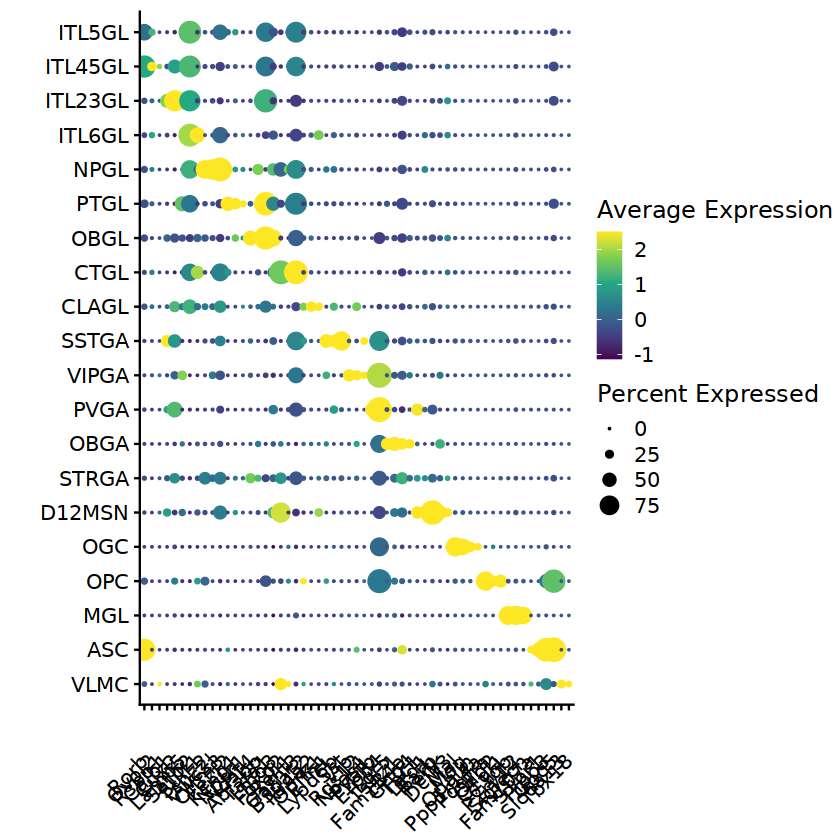

In [11]:
### marker gene dotplot
valid <- rownames(mmg@meta.data[mmg$RNA_keep_cells == "True", ]) 
obj <- subset(mmg, cells = valid)
obj@meta.data <- obj@meta.data %>% mutate(Anno0.8_yel = factor(Anno0.8_yel, levels = corder))
DotPlot(obj, features = mtp, group.by = "Anno0.8_yel", ) + scale_color_viridis_c() +
ylab("") + xlab("") + 
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1))

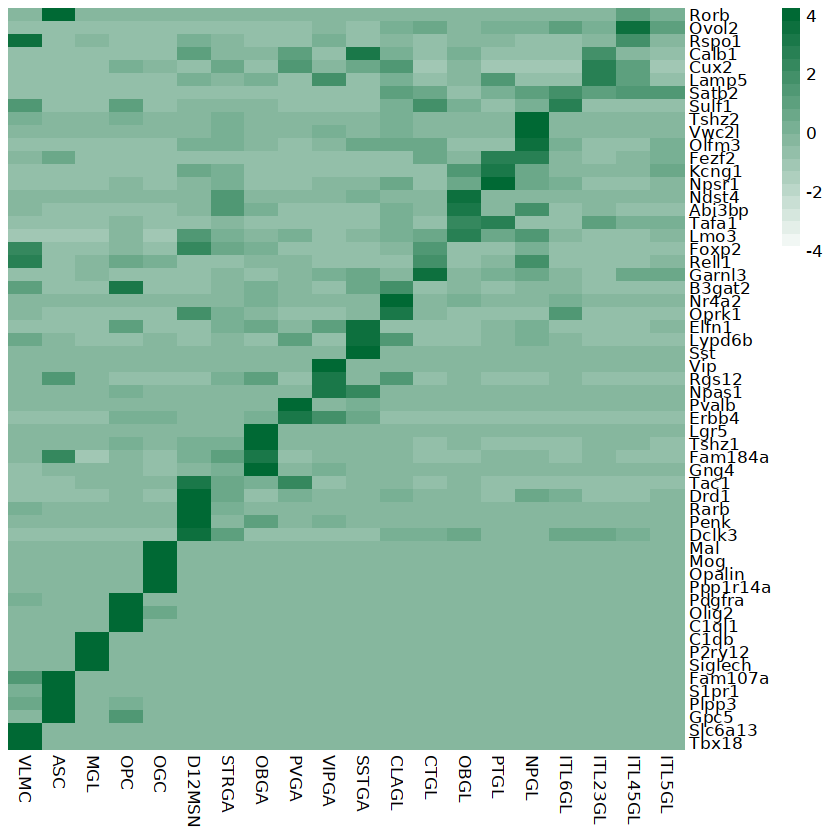

In [13]:
### RNA marker gene heatmap
set.seed(921)
obj <- subset(mmg, subset = RNA_keep_cells == "True")
obj_RNA <- AverageExpression(obj, assays = "RNA", group.by = "Anno0.8_yel")
t1 <- obj_RNA$RNA[mtp, corder] %>%
pheatmap::pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, 
                   border_color = "NA", 
                   color = colorRampPalette(c("white", "#006934"))(20))

In [14]:
### filter H3K27ac...
valid <- rownames(d1@meta.data[d1$DNA_keep_cells == "True" & d1$RNA_keep_cells != "False", ]) 
d1_valid <- subset(d1, cells = valid)
d1_GA <- AverageExpression(d1_valid, assays = "GA", group.by = "rna_Anno0.8")
mmtp <- intersect(mtp, rownames(d1_GA$GA))
### filter H3K27me3...
valid <- rownames(d2@meta.data[d2$DNA_keep_cells == "True" & d2$RNA_keep_cells != "False", ]) 
d2_valid <- subset(d2, cells = valid)
d2_GA <- AverageExpression(d2_valid, assays = "GA", group.by = "rna_Anno0.8")

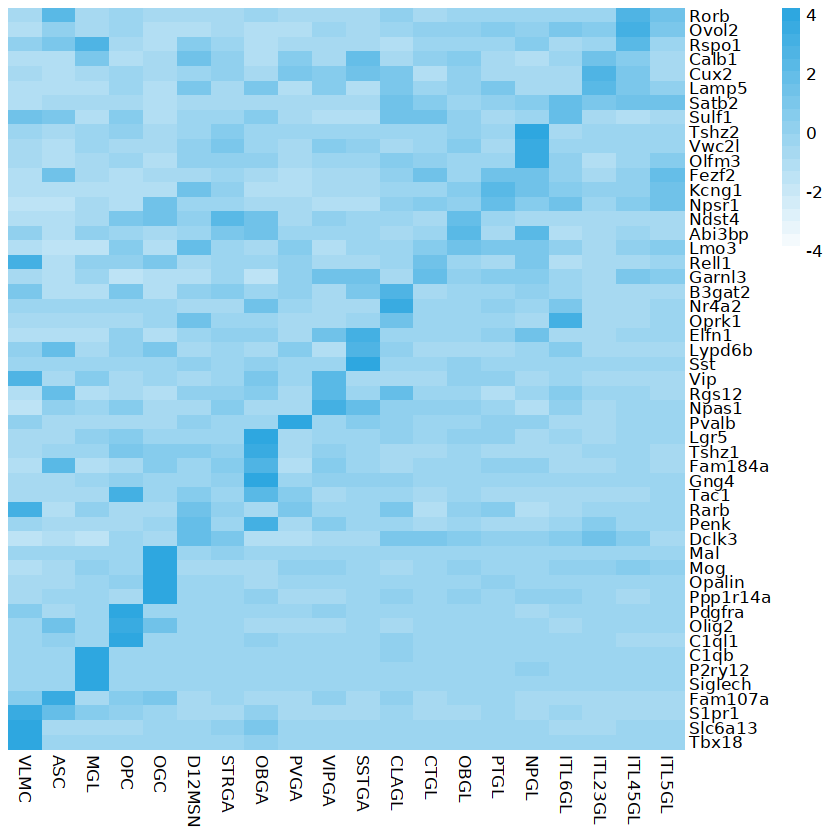

In [15]:
### H3K27ac GA heatmap
t2 <- d1_GA$GA[mmtp, corder] %>%
pheatmap::pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, border_color = "NA",
                   color = colorRampPalette(c("white", "#2EA7E0"))(20))

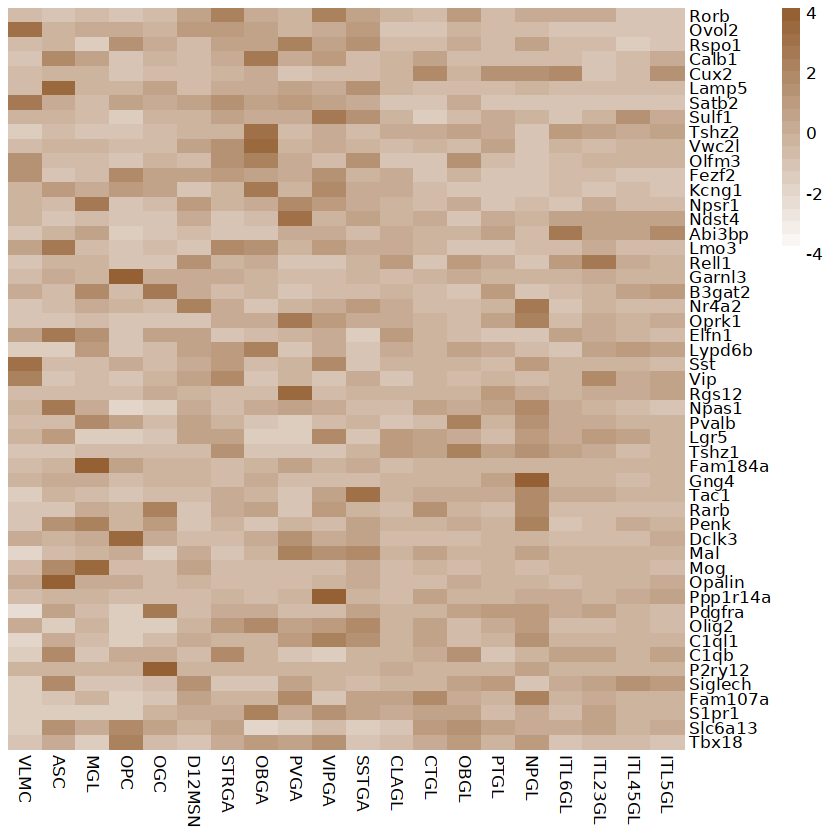

In [16]:
### H3K27me3 GA heatmap
t3 <- d2_GA$GA[mmtp, corder] %>%
pheatmap::pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, border_color = "NA",
                   color = colorRampPalette(c("white", "#956134"))(20))